In [97]:
from __future__ import division, print_function, unicode_literals

import pandas as pd
import numpy as np
import os
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import lightgbm as lgb
import xgboost as xgb

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)
    
import warnings
warnings.filterwarnings('ignore')

In [98]:
# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

# Create an XGBoost-compatible metric from Gini

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score

In [158]:
# Read in our input data
train_path = "C:\\Users\\Rui\\source\\Kaggle\\Safe_Driver_Prediction\\train.csv"
test_path = "C:\\Users\\Rui\\source\\Kaggle\\Safe_Driver_Prediction\\test.csv"

train_original = pd.read_csv(train_path, sep = ',')
test_original = pd.read_csv(test_path, sep = ',')

# This prints out (rows, columns) in each dataframe
print('Train shape:', train_original.shape)
print('Test shape:', test_original.shape)

Train shape: (595212, 59)
Test shape: (892816, 58)


0    0.963552
1    0.036448
Name: target, dtype: float64
Saving figure imbalanced target


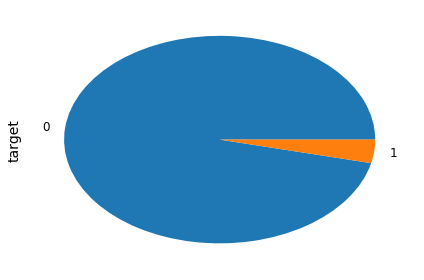

In [159]:
# imbalanced datasets
prop_buy = train_original.target.value_counts()/len(train_original)
print(prop_buy)
prop_buy.plot(kind = 'pie')
save_fig("imbalanced target")

In [160]:
id_train = train_original['id'].values
y_train = train_original['target'].values
train = train_original.drop(['id', 'target'], axis = 1)
id_test = test_original['id'].values
test = test_original.drop(['id'], axis = 1)

In [161]:
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (595212, 57)
Test shape: (892816, 57)


In [162]:
# replace -1 with NA
train = train.replace(-1, np.NaN)
test = test.replace(-1, np.NaN)

Saving figure covariance matrix heatmap


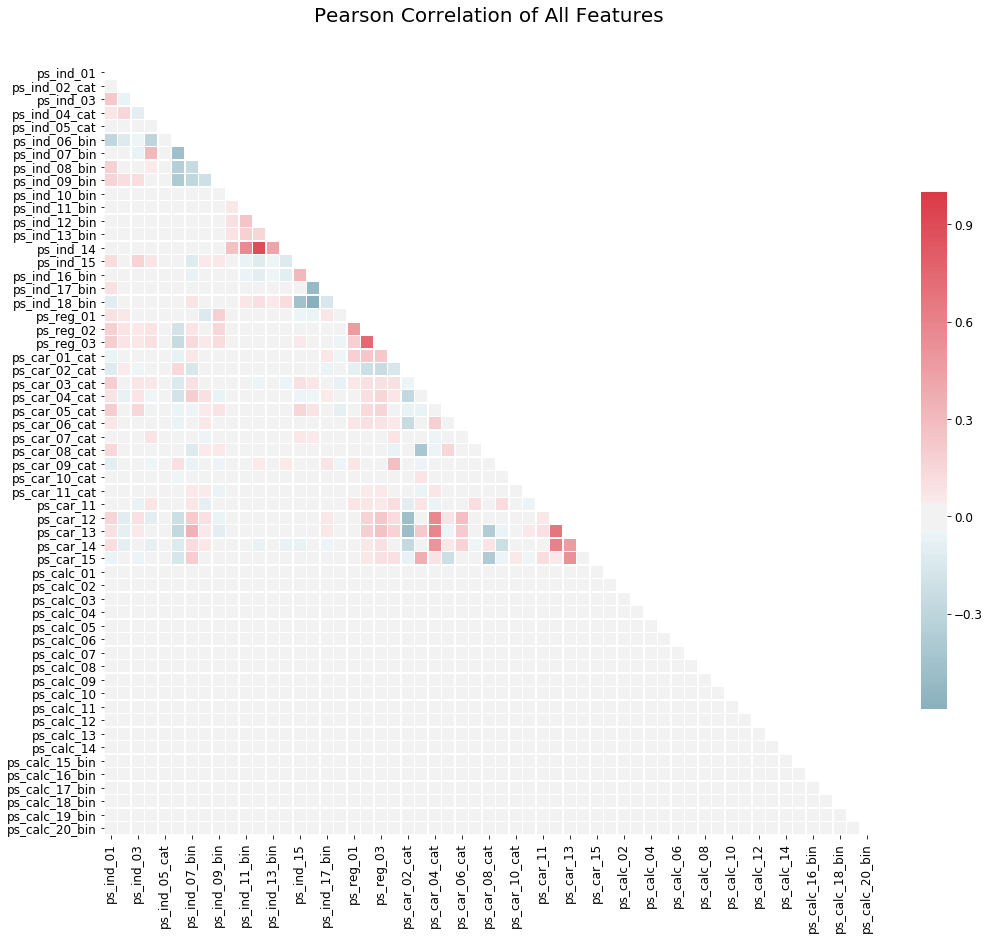

In [163]:
corr = train.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(220, 10, as_cmap=True)


plt.title('Pearson Correlation of All Features', y=1.05, size=20)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
save_fig("covariance matrix heatmap")

In [164]:
# NA statistics
train_na_counts = train.isnull().sum().div(len(train), axis = 0)*100
train_na_counts[train_na_counts > 5]

ps_reg_03        18.106490
ps_car_03_cat    69.089837
ps_car_05_cat    44.782531
ps_car_14         7.160474
dtype: float64

In [165]:
# NA statistics
test_na_counts = test.isnull().sum().div(len(test), axis = 0)*100
test_na_counts[test_na_counts > 5]

ps_reg_03        18.109442
ps_car_03_cat    69.097216
ps_car_05_cat    44.842274
ps_car_14         7.146489
dtype: float64

In [166]:
# check those features whose percent of missing values is less than 5%
# make sure the same situation in train and test
train_small_missing_features = np.array(train_na_counts[(train_na_counts > 0) & (train_na_counts < 5)].index)
test_small_missing_features = np.array(train_na_counts[(train_na_counts > 0) & (train_na_counts < 5)].index)
print(train_small_missing_features)
print(test_small_missing_features)

['ps_ind_02_cat' 'ps_ind_04_cat' 'ps_ind_05_cat' 'ps_car_01_cat'
 'ps_car_02_cat' 'ps_car_07_cat' 'ps_car_09_cat' 'ps_car_11' 'ps_car_12']
['ps_ind_02_cat' 'ps_ind_04_cat' 'ps_ind_05_cat' 'ps_car_01_cat'
 'ps_car_02_cat' 'ps_car_07_cat' 'ps_car_09_cat' 'ps_car_11' 'ps_car_12']


In [167]:
for feature in train_small_missing_features:
    print('Correlation ranking with feature: %s' % feature)
    print(corr[feature].sort_values(ascending=False))


Correlation ranking with feature: ps_ind_02_cat
ps_ind_02_cat     1.000000
ps_ind_04_cat     0.146363
ps_ind_09_bin     0.110553
ps_reg_02         0.083905
ps_reg_03         0.072150
ps_reg_01         0.060219
ps_car_02_cat     0.045386
ps_ind_08_bin     0.031194
ps_car_07_cat     0.023223
ps_car_05_cat     0.021982
ps_car_03_cat     0.019831
ps_car_11         0.019660
ps_ind_07_bin     0.016322
ps_car_11_cat     0.015204
ps_ind_16_bin     0.011808
ps_car_10_cat     0.011154
ps_car_09_cat     0.007425
ps_car_08_cat     0.001438
ps_calc_18_bin    0.001117
ps_calc_02        0.000959
ps_calc_16_bin    0.000865
ps_ind_11_bin     0.000720
ps_calc_01        0.000711
ps_calc_17_bin    0.000600
ps_calc_09        0.000346
ps_calc_19_bin    0.000150
ps_calc_11        0.000127
ps_car_01_cat     0.000079
ps_calc_10        0.000016
ps_calc_06       -0.000004
ps_calc_07       -0.000173
ps_calc_15_bin   -0.000209
ps_ind_18_bin    -0.000294
ps_calc_03       -0.000334
ps_calc_14       -0.000623
ps_ind_

In [184]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
train1 = train.dropna()
y = train1['ps_ind_04_cat']
X = train1[columns]
lr = LogisticRegression(C = 1e3)
lr.fit(X, y)
y_pred = lr.predict(X) 
print(confusion_matrix(y, y_pred))

[[54549 15106]
 [23076 32200]]


In [133]:
# since the small feature
for df in [train, test]:
    for feature in train_small_missing_features:
        # not categorical features, fill with mean
        if feature in ['ps_car_11' 'ps_car_12']:
            df[feature].fillna(df[feature].mean()[0], inplace = True)
        else:
            

In [141]:
train.ps_ind_04_cat.value_counts()

0.0    347048
1.0    248164
Name: ps_ind_04_cat, dtype: int64

In [126]:
train.ps_ind_02_cat.isnull().sum()

0

In [74]:
#count the numbers of int64, float64, bool or object/string features
int_features = train.select_dtypes(include = ['int64']).columns.values
float_features = train.select_dtypes(include = ['float64']).columns.values
bool_features= train.select_dtypes(include = ['bool']).columns.values
categorical_features = train.select_dtypes(include = ['object']).columns.values
print('int_features:', int_features)
print('float_features:', float_features)
print('bool_features:', bool_features)
print('categorical_features:', categorical_features)